# Source Code for implementing ACO for the MAPF problem

* Create algorithm for ACO
* Create test promles
* Create algorithm for time-expansion of the graph
* Create Multi-Agent-ACO solver

In [1]:
# install the required packages
%pip install matplotlib pandas seaborn numpy networkx ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=np.inf)
import networkx as nx
import ipywidgets as widgets

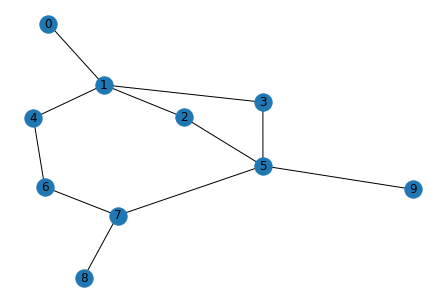

In [3]:
G = nx.Graph()
G.add_edge(0, 1, weight=1)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 5, weight=1)
G.add_edge(1, 4, weight=3)
G.add_edge(2, 5, weight=1)
G.add_edge(4, 6, weight=1)
G.add_edge(5, 7, weight=1)
G.add_edge(6, 7, weight=3)
G.add_edge(7, 8, weight=1)
G.add_edge(5, 9)
nx.draw(G, with_labels=True)

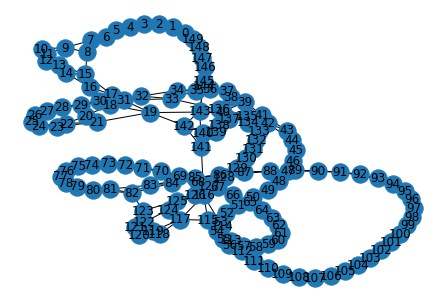

In [4]:
G = nx.watts_strogatz_graph(150,4, 0.01, seed=42)
nx.draw(G,with_labels=True)
for e in G.edges():
    G[e[0]][e[1]]['weight']= 0.5 + np.random.rand()
graphstart = 0
graphgoal = 75

In [5]:
m = nx.adjacency_matrix(G)

In [16]:
class Ant:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = nx.adjacency_matrix(G).todense()):
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        
        assert pheromones.shape == adjacency.shape
        
        for i in range(adjacency.shape[0]):
            for j in range(adjacency.shape[1]):
                if adjacency[i, j] == 0:
                    self.pheromones[i, j] = 0
        
        self.setup()
        
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def delayed_update(self):
        amount = len(self.path) * 0.1 / self.distance
        for i in range(len(self.path)-1):
            self.pheromones[self.path[i], self.path[i+1]] += amount
            self.pheromones[self.path[i+1], self.path[i]] += amount
            
    
    def random_selection(self, new):
        return np.random.choice(new)
    
    def roulette_wheel_selection(self, new):
        probs = {k : self.pheromones[self.state, k] for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                x = k
                break
        assert(cutoff <= 0)
        return x

    def setup(self):
        self.state = self.start
        self.path = [self.start]
        self.distance = 0
            
    def step(self, selection=None, delayed_update=False, reverse_direction=True):
        if not selection:
            selection = self.roulette_wheel_selection
        # compute next possible states $new
        new = [node for node in range(len(self.adjacency)) if not(node in self.path or self.adjacency[self.state, node] == 0)]
        
        #print(f"t: {self.path}, s: {self.state}, new: {new}")
        # in case no more states are possible: return
        if not new:
            #self.update_pheromones(delta=-0.01)
            self.setup()
            return False
        
        # pick a new state from the list
        self.state = selection(new)
        self.path.append(self.state)
        d = self.adjacency[self.path[-2], self.path[-1]]
        #print(d)
        self.distance += d
        
        if not delayed_update:
            self.pheromones[self.path[-2], self.path[-1]] += .1 / d
            self.pheromones[self.path[-1], self.path[-2]] += .1 / d


        if self.state == self.goal:
            if delayed_update:
                self.delayed_update()
            if reverse_direction:
                self.start, self.goal = self.goal, self.start
            self.setup()
            return False
        return True
        
        
    def run(self, selection=None):
        self.state = self.start
        self.path = [self.start]
        self.distance = 0
        while self.step(selection=selection):
            pass
        return self.path
    
    def draw_pheromones(self, label=True):
        G = nx.from_numpy_matrix(self.pheromones)
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [w['weight'] * 2 for u, v, w in G.edges(data=True)]
        nx.draw(G,pos=pos,with_labels=True, width=width)
        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    def draw_adjacency(self):
        G = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(G)
        nx.draw(G,pos=pos,with_labels=True)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.1f}" for k, v in weight.items()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        

        

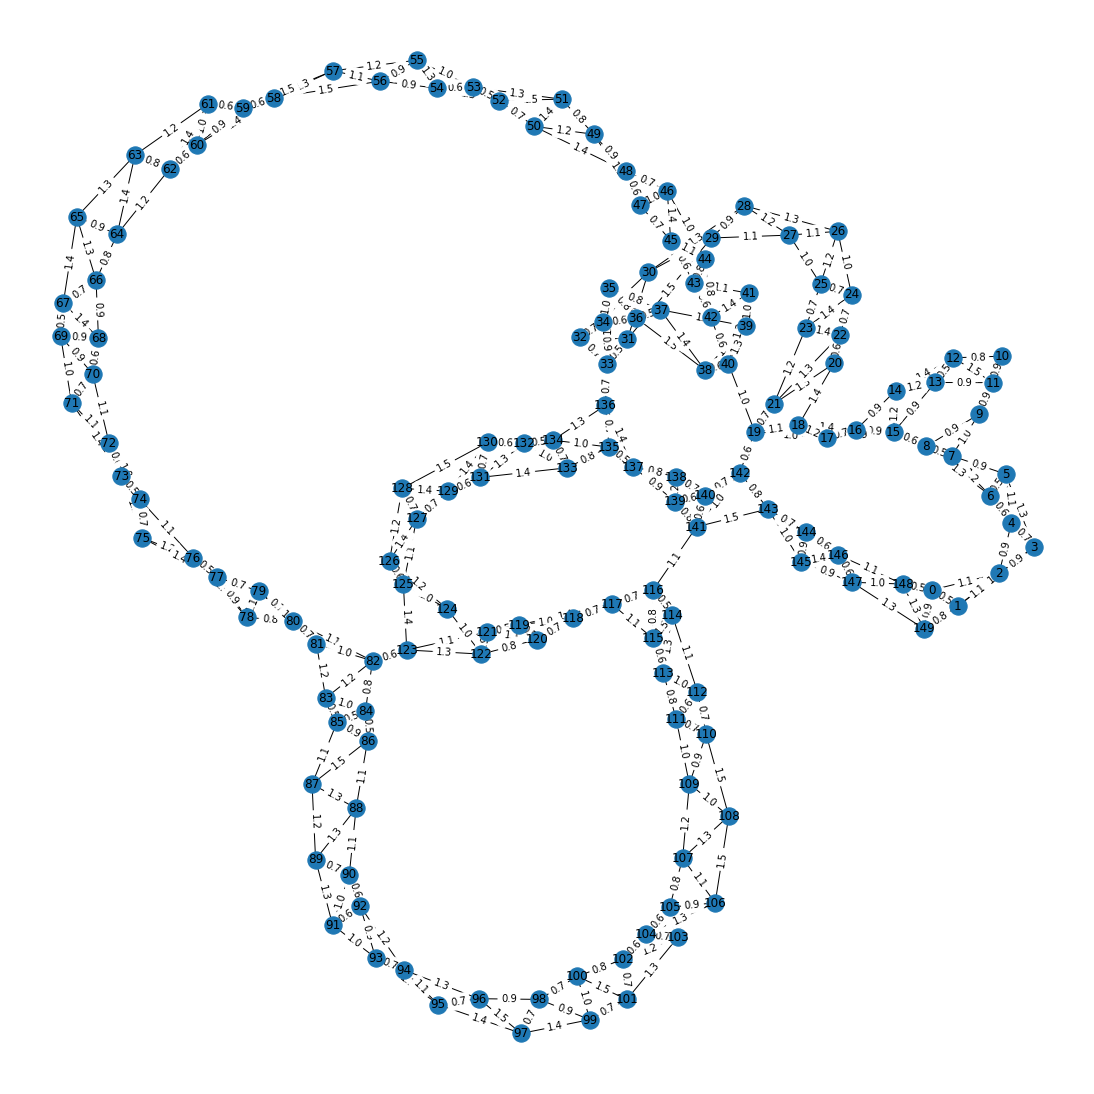

In [21]:
p = 0.5 * np.ones_like(m.todense())
ants = [Ant(start=graphstart, goal=graphgoal, pheromones=p, adjacency=m.todense())for _ in range(10)]
pheromone_timeline = []

for _ in range(1000):
    for a in ants:
        a.step(delayed_update=True, reverse_direction=True)
    ants[0].evaporate(gamma=0.99)
    pheromone_timeline.append(ants[0].pheromones.copy())
    
plt.figure(figsize=(15,15))
ants[0].draw_adjacency()
plt.show()


In [22]:
def drawfunction(generation):
    plt.figure(figsize=(15,15))
    a = Ant(pheromones=pheromone_timeline[generation], adjacency=m.todense())
    a.draw_pheromones(label=False)
    plt.show()
    
widgets.interact(drawfunction, generation=widgets.IntSlider(min=0,max=len(pheromone_timeline)-1,step=1,value=10));

interactive(children=(IntSlider(value=10, description='generation', max=999), Output()), _dom_classes=('widget…

In [23]:
#a.pheromones

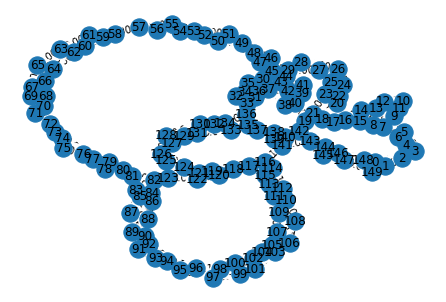

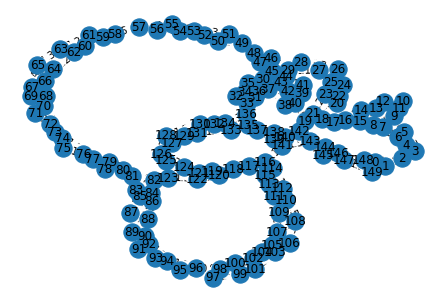

In [24]:
a.draw_pheromones()
plt.show()
a.draw_adjacency()
plt.show()

In [11]:
m

<150x150 sparse matrix of type '<class 'numpy.float64'>'
	with 600 stored elements in Compressed Sparse Row format>

In [12]:
adj = m.todense()

In [13]:
len(adj)

150

In [14]:
l = 0.2
f"{l:.2f}"

'0.20'

In [15]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 0.5407644559174218}), (0, 149, {'weight': 0.9193591463005997}), (0, 2, {'weight': 1.1053781472645245}), (0, 148, {'weight': 0.5026893117834738}), (1, 2, {'weight': 1.0978402721756801}), (1, 3, {'weight': 1.4870024062894358}), (1, 149, {'weight': 0.7566632721686203}), (2, 3, {'weight': 0.856265210227529}), (2, 4, {'weight': 0.8665042865394845}), (3, 4, {'weight': 0.6591168869618234}), (3, 5, {'weight': 1.2934124344640745}), (4, 5, {'weight': 1.1303126871580707}), (4, 6, {'weight': 0.619331431578425}), (5, 6, {'weight': 0.5402218927418302}), (5, 7, {'weight': 0.9263702008203921}), (6, 7, {'weight': 1.1674902569236858}), (6, 8, {'weight': 1.2820528201220371}), (7, 8, {'weight': 0.5106202101713319}), (7, 9, {'weight': 1.0232114784422885}), (8, 9, {'weight': 0.948169925580514}), (8, 15, {'weight': 0.6059871965374979}), (9, 10, {'weight': 0.9321968965982576}), (9, 11, {'weight': 0.9014068430611931}), (10, 11, {'weight': 0.8806339562610019}), (10, 12, {'weight'